This script produces figures and analyses for the precue (rule-based) condition in the section "Rule- and stimulus-based biases exhibited distinct physiological signatures".

Relies on regressions produced by precue_pupil_lme6_FINAL.R, precue_pupil_task_id4_FINAL.R, precue_pupil_lme_stim_FINAL.R.

Produces all subplots of Figure 5.

In [1]:
imatlab_export_fig('print-svg')
set(groot,'defaultfigurecolor',[1 1 1]);
set(groot,'DefaultAxesFontName','Arial')

%set paths (might want to change where this ultimately goes)
addpath('../');

DS = 500;
rmNaN = true;

%set directories/files
TASK_DATA_DIR = fullfile('..','data');
SAVE_DIR = 'C:\Users\ntard\OneDrive\Goldlab\AuditoryPriors\cached data';

DATA_VALID = 'valid_pupil_03-Feb-2021.mat';
DATA_BL = 'pupil_data_bl_13-Jan-2021.mat';
if DS==500
    DATA_FILE = 'pupil_data_ds500_13-Jan-2021.mat';
    DATA_META = 'pupil_metadata_ds500_13-Jan-2021.mat';
elseif DS==50
    DATA_FILE = 'pupil_data_ds50_15-Jan-2021.mat';
    DATA_META = 'pupil_metadata_ds50_15-Jan-2021.mat';
else
    DATA_FILE = 'pupil_data_13-Jan-2021.mat';
    DATA_META = 'pupil_metadata_13-Jan-2021.mat';
end

TASK_DATA_FILE = 'priorOnly_pretoneOnly_pretone_pL_pretone_pH_pretone5_05-Feb-2021.csv';

%read in task data
task_data = read_data_csv(fullfile(TASK_DATA_DIR,TASK_DATA_FILE));
task_data(~strcmp(task_data.optionName,'priorOnly'),:) = [];

%regression bounds
t_lim = [-900 900];

In [2]:
%set up task variables for joining w/ pupil

task_data.congruent = double((task_data.prior == 2 & task_data.choice01 == 1) | (task_data.prior == -2 & task_data.choice01 == 0));
task_data.congruent(task_data.prior==0) = -1;
task_data.congruentS = double((task_data.prior == 2 & task_data.isH == 1) | (task_data.prior == -2 & task_data.isH == 0));
task_data.congruentS(task_data.prior==0) = -1;

task_join_vars = {'SNR','prior','isH','success','choice01','congruent','congruentS'};

In [3]:
%load in/clean all data
[~,data,metadata,baselines,task_data,ID2subj,validTrials,validTrialsBL] = ...
    load_pd_data(...
        fullfile(SAVE_DIR,DATA_FILE),...
        fullfile(SAVE_DIR,DATA_META),...
        fullfile(SAVE_DIR,DATA_BL),...
        DATA_VALID,...
        task_data,...
        task_join_vars);

median trials/subject: 363 | min: 96 | max 562

median baseline trials/subject: 4.425000e+02 | min: 168 | max 574

priorOnly N: 44

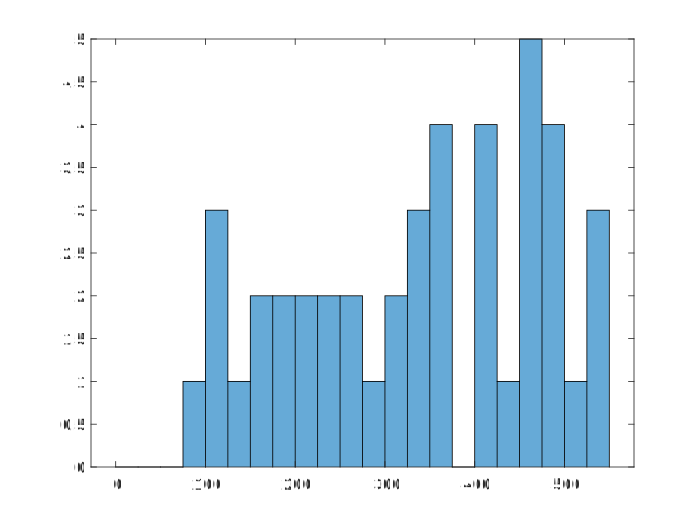

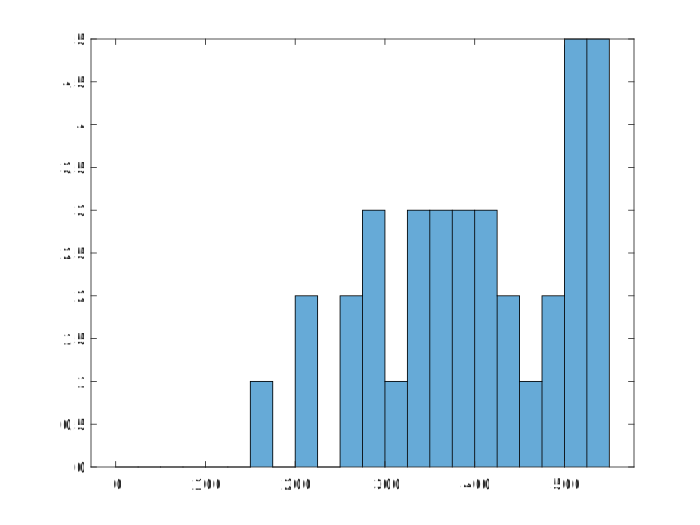

In [4]:
%how many trials left/subject for pupil data?
trialList = unique(data(:,{'dataID','trialN'}),'rows');
vt_sum = varfun(@length,trialList,'InputVariables','trialN','GroupingVariables','dataID');
figure();histogram(vt_sum.length_trialN,[0:25:max(vt_sum.length_trialN)])
fprintf('median trials/subject: %d | min: %d | max %d\n\n',median(vt_sum.length_trialN),...
    min(vt_sum.length_trialN), max(vt_sum.length_trialN))

%how many trials left/subject for baseline pupil data?
trialListBL = unique(baselines(:,{'dataID','trialN'}),'rows');
vt_sumBL = varfun(@length,trialListBL,'InputVariables','trialN','GroupingVariables','dataID');
figure();histogram(vt_sumBL.length_trialN,[0:25:max(vt_sumBL.length_trialN)])
fprintf('median baseline trials/subject: %d | min: %d | max %d\n\n',median(vt_sumBL.length_trialN),...
    min(vt_sumBL.length_trialN), max(vt_sumBL.length_trialN))
    
fprintf('priorOnly N: %d',height(vt_sum))

#### output for R

In [5]:
%% output for R
if false
    if DS~=50
        error('You only want to output 50 Hz!')
    end
    writetable(data,fullfile(SAVE_DIR,sprintf('pupil_data_ds%d_forR_%s.csv',DS,date())));
    writetable(baselines,fullfile(SAVE_DIR,sprintf('pupil_data_bl_forR_%s.csv',date())));
    writetable(ID2subj,fullfile(SAVE_DIR,sprintf('pupil_data_ds%d_id2subj_forR_%s.csv',DS,date())))
end

## choice-aligned analyses

In [6]:
%% relative to response
data_ave_choice_subj = varfun(@nanmean,data(data.trial_time_choice >= -1050 & data.trial_time_choice <= 1000,:),...
    'InputVariables','pupilCblz',...
    'GroupingVariables',{'dataID','success','trial_time_choice'});
data_ave_choice = summary_stats(data_ave_choice_subj,'nanmean_pupilCblz',...
    {'success','trial_time_choice'},1);
 
data_ave_choice_congruent_subj = varfun(@nanmean,...
    data(data.trial_time_choice >= -1050 & data.trial_time_choice <= 1000,:),'InputVariables','pupilCblz',...
    'GroupingVariables',{'dataID','success','congruent','trial_time_choice'});
data_ave_choice_congruent = summary_stats(data_ave_choice_congruent_subj,'nanmean_pupilCblz',...
    {'success','congruent','trial_time_choice'},1);

congruent=1
congruent=2
congruent=3
congruent=1
congruent=2
congruent=3


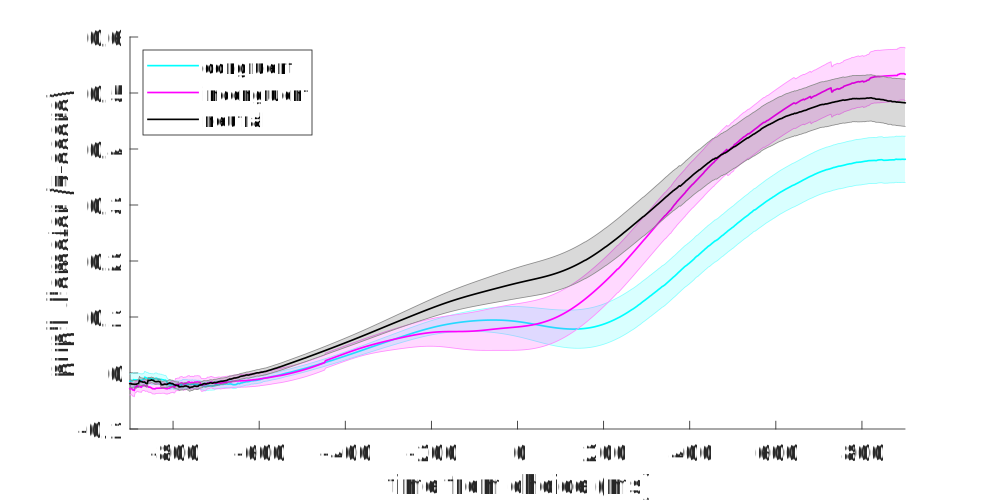

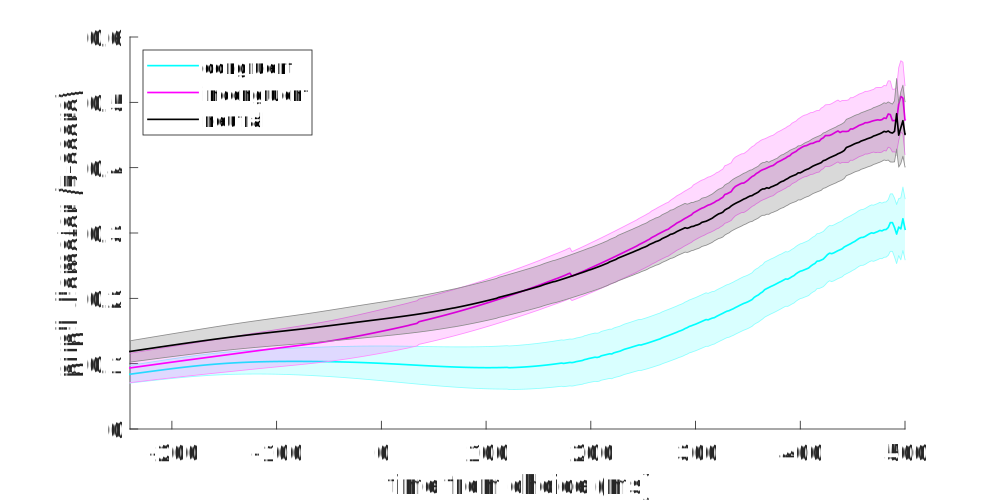

In [7]:
% just correct trials(Fig 5a)
set(groot,'DefaultAxesFontSize',15)
this_subplotv = @(m,n,p) subtightplot(m,n,p,.09,[.2 .2],[0.1 0.01]);

line_specs = {'c','m','k'};
conds = [1,0,-1];
success = [1,0];
success_title = {'correct','incorrect'};
%figure();hold on;
for c=1:length(success)
    f=figure();hold on;
    %this_subplotv(1,2,c);hold on
    %subplot(1,1,1);hold on;
    hC = [];
    for j=1:length(conds)
        fprintf('congruent=%d\n',j);

        h=shadedErrorBar(data_ave_choice_congruent.trial_time_choice(...
            data_ave_choice_congruent.congruent == conds(j) & data_ave_choice_congruent.success == success(c)), ...
            data_ave_choice_congruent.nanmean_nanmean_pupilCblz(...
            data_ave_choice_congruent.congruent == conds(j) & data_ave_choice_congruent.success == success(c)), ...
            data_ave_choice_congruent.nansem_nanmean_pupilCblz(...
            data_ave_choice_congruent.congruent == conds(j) & data_ave_choice_congruent.success == success(c)), ...
            line_specs{j},1);
        hC = [hC h.mainLine];
    end
    %title([success_title(c)])
    %xlabel('time from choice (ms)')
    if true %success(c)==1
        legend(hC,{'\fontsize{12}congruent', '\fontsize{12}incongruent', '\fontsize{12}neutral'},...
        'Location', 'northwest')
    end
    if success(c)==1
        xlim(t_lim);
    else
        xlim([-240 500]);
    end
    ylabel('pupil diameter (z-score)')
    xlabel('time from choice (ms)')
    [hC.LineWidth] = deal(1); 
    
    set(gcf,'Renderer','painters')
    f.Position = [400 400 800 400];
end
%suplabel('time from choice (ms)','x',[.08 .2 .84 .84]);


set(groot,'DefaultAxesFontSize','factory')


Given that the incorrect trials pattern the same way as the correct trials for choice-coded congruence, it would appear that pupil responses are better characterized as choice aligned---strength of regression should also bear this out---might need quantification eventually.

## Choice regression

Pupil data were downsampled to 50 Hz. A linear mixed-effects model was then run at every time point between -240 ms and 1000 ms (-240 and 500 ms for incorrect trials) relative to choice of the form:


$$ pupil_t = \beta_{0_t} + \beta_{congruent1_t} + \beta_{congruent2_t} + \beta_{isH_t} + \beta_{|SNR|_t} + \beta_{bl_t} + \beta_{posX_t} + \beta_{posY_t} $$

Separate models were run for correct and incorrect trials. The model at each time point was initial fit with the maximal random effects structured. In cases of convergence/boundary issues, the complexity of the random effects structure was iteratively reduced following the recommendations of Bates et al., 2015. All categorical variables (congruent, isH) were effect coded. Continuous variables were z-scored across subjects, except for baseline pupil; because it was already z-scored within-subject, it was only mean-centered across subjects. Also note that congruence is relative to choice in these models, not stimulus.

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


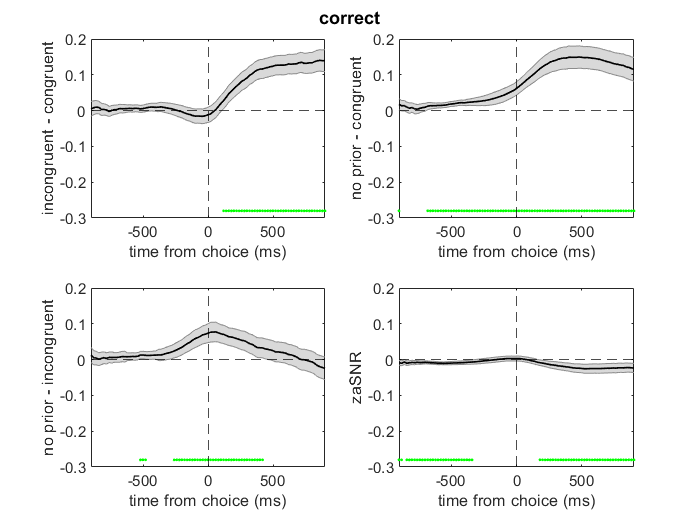

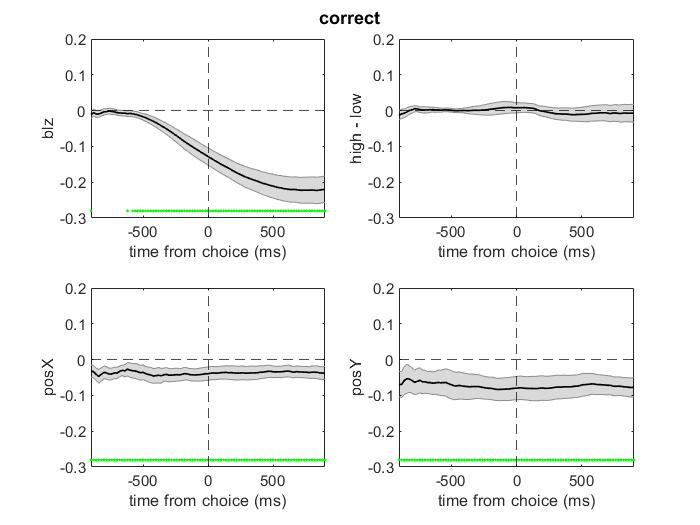

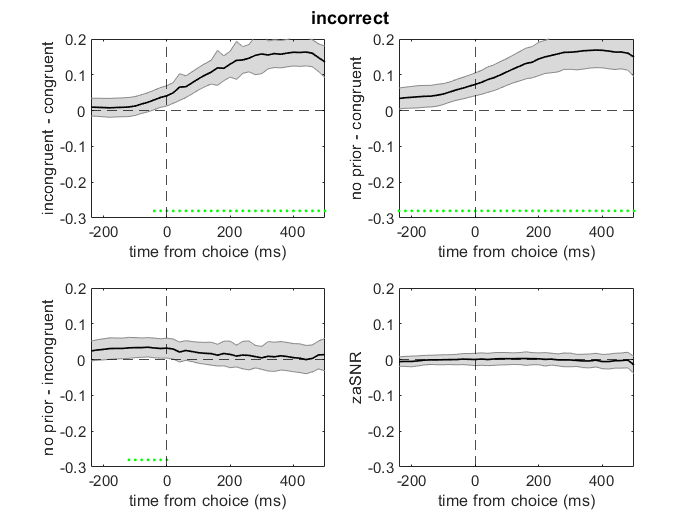

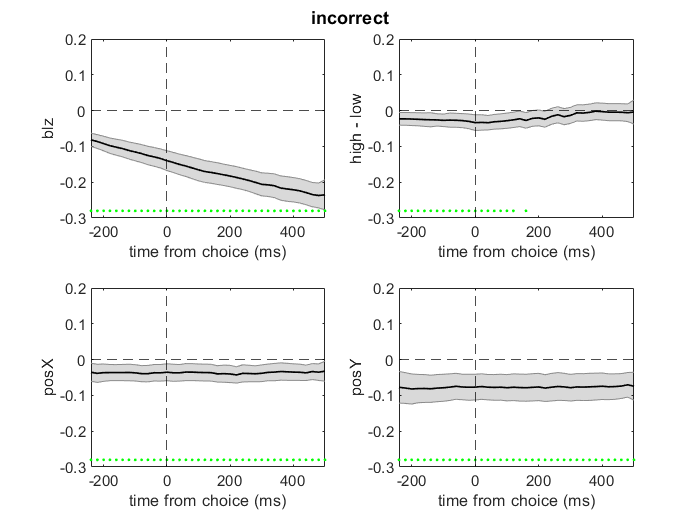

In [8]:
%these will probably be combined in R eventually(?)
p_var = 'p_corr';

CHOICE_LM_FILE = {'choice_lm_final_2021-05-19.csv','choice_i_lm_final_2021-04-29.csv'};
CHOICE_EMM_FILE = {'choice_emm_final_2021-05-19.csv','choice_i_emm_final_2021-04-29.csv'};

choice_lm = [];
choice_emm = [];
choice_lm_success = [1 0];
for i=1:length(choice_lm_success)
    this_choice_lm = readtable(CHOICE_LM_FILE{i});
    this_choice_lm.success = repmat(choice_lm_success(i),...
        height(this_choice_lm),1);
    choice_lm = [choice_lm; this_choice_lm];
    
    this_choice_emm = readtable(CHOICE_EMM_FILE{i});
    this_choice_emm.p_corr = nan(height(this_choice_emm),1);
    this_choice_emm.success = repmat(choice_lm_success(i),...
        height(this_choice_emm),1);
    choice_emm = [choice_emm; this_choice_emm];
    
    clear this_choice_lm this_choice_emm
end
%choice_lm = readtable(CHOICE_LM_FILE);
%choice_emm = readtable(CHOICE_EMM_FILE);
%choice_emm.p_corr = nan(height(choice_emm),1);
choice_lm = [choice_lm;choice_emm];
clear choice_emm;

%now flip contrasts for ease of interpretation
flip_cs.orig = {'congruent - incongruent','congruent - no prior',...
    'incongruent - no prior'};
flip_cs.new = {'incongruent - congruent','no prior - congruent',...
    'no prior - incongruent'};
flip_lm = choice_lm(ismember(choice_lm.param,flip_cs.orig),:);
flip_lm{:,{'B','t','CI_lower','CI_upper'}} = -flip_lm{:,{'B','t','CI_lower','CI_upper'}};
flip_lm.Properties.VariableNames({'CI_lower','CI_upper'}) = {'CI_upper','CI_lower'};
flip_lm = movevars(flip_lm,'CI_upper','After','CI_lower');
flip_lm.param = replace(flip_lm.param,flip_cs.orig,flip_cs.new);
choice_lm(ismember(choice_lm.param,flip_cs.orig),:) = flip_lm;
clear flip_lm

choice_lm = sortrows(choice_lm,{'success','time','param'}); % {'time','param'});
choice_lm.CI_halfwidth = choice_lm.B - choice_lm.CI_lower;

%restrict to timepoints we are going to actually include in analysis before fdr correct
t_lim = [-900 900];
choice_lm(choice_lm.time<t_lim(1) | choice_lm.time>t_lim(2),:) = [];

%now FDR correct! [NOT IMPLEMENTED IN R as of now]
group_correct = {'incongruent - congruent','no prior - congruent', 'no prior - incongruent'};
choice_lm = lm_adjust(choice_lm,group_correct);

%plot_params = {{'congruent - incongruent','congruent - no prior',...
%    'incongruent - no prior','zaSNR'},{'blz','high - low','posX','posY'}};
plot_params = {{'incongruent - congruent','no prior - congruent',...
    'no prior - incongruent','zaSNR'},{'blz','high - low','posX','posY'}};
ylim_min = [-.3 -.3]; %[-.275,-.63];
success_title = {'correct','incorrect'};
for s=1:length(choice_lm_success)
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        figure();
        for i=1:length(this_plot_params)
            subplot(2,2,i)
            this_param = this_plot_params{i};
            this_choice_lm = choice_lm(strcmp(choice_lm.param,this_param) & choice_lm.success==choice_lm_success(s),:);
            h_choice_lm=shadedErrorBar(this_choice_lm.time, ...
                this_choice_lm.B, ...
                this_choice_lm.CI_halfwidth, ...
                '-k',1);
            xlabel('time from choice (ms)')
            ylabel(this_param)
            h_choice_lm.mainLine.LineWidth = 1;
            hold on;

            %add significance line
            %sum(choice_lm.p_fdr(strcmp(choice_lm.param,'ee')) < 0.05) ...
            %    ==length(choice_lm.p_fdr(strcmp(choice_lm.param,'ee')))
            choice_sig = double(this_choice_lm.(p_var) < 0.05);
            choice_sig(choice_sig == 0) = NaN;
            choice_sig_y = ylim_min(pp) + (.1 - ylim_min(pp))*.05;%min(choice_lm.CI_lower(strcmp(choice_lm.param,this_param))) - .05;
            h_choice_sig = plot(this_choice_lm.time,...
                choice_sig .* choice_sig_y,'.','LineWidth',1, 'Color', 'green','MarkerSize',5);
            %h_choice_sig = line([min(choice_lm.trial_time_choice),...
            %    max(choice_lm.trial_time_choice)],[.01 .01],'Color','black','LineWidth',1.5)
            %h_choice_lines = [h_choice_lm.mainLine h_choice_lm.patch h_choice_sig];
            %legend(h_choice_lines,{'\bf\beta', '95% CI','p_{corrected} < .05'},...
            %    'Location', 'northwest')
            yline(0,'--k');
            xline(0,'--k');
            ylim([ylim_min(pp) .2]);
            xlim([min(choice_lm.time(choice_lm.success==choice_lm_success(s))) ...
                max(choice_lm.time(choice_lm.success==choice_lm_success(s)))]);

            clear this_choice_lm
        end
        %suplabel(sprintf('success=%d',choice_lm_success(s)),'t',...
        %    [.08 .1 .84 .84]);
        suplabel(success_title{s},'t',...
            [.08 .1 .84 .84]);
    end
end


In [9]:
% when are first sig time points for contrasts
for i=1:length(group_correct)
    c_choice_lm=choice_lm(ismember(choice_lm.param,group_correct{i}) & ...
        choice_lm.success==1,:);
    fprintf('%s min: %d / max: %d\n\n',group_correct{i},...
    min(c_choice_lm.time(c_choice_lm.p_corr<.05)),...
    max(c_choice_lm.time(c_choice_lm.p_corr<.05)))
end

incongruent - congruent min: 120 / max: 900

no prior - congruent min: -900 / max: 900

no prior - incongruent min: -520 / max: 420



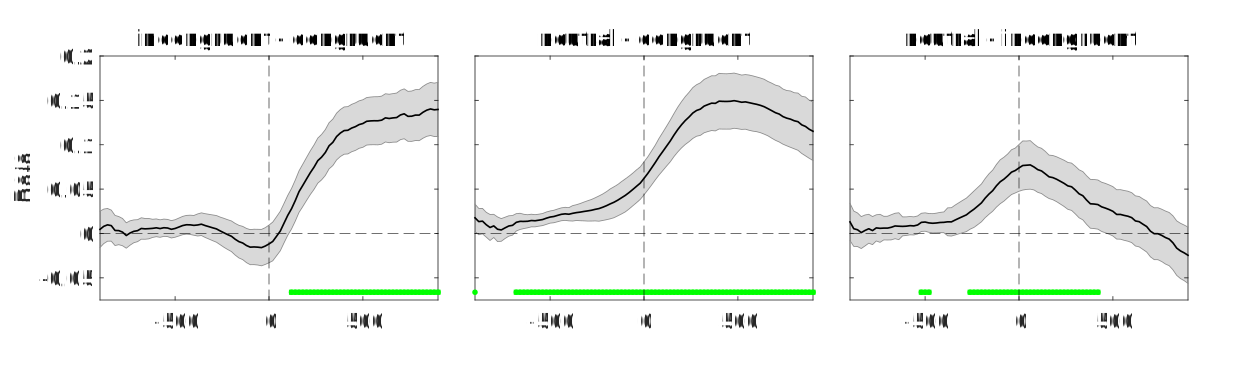

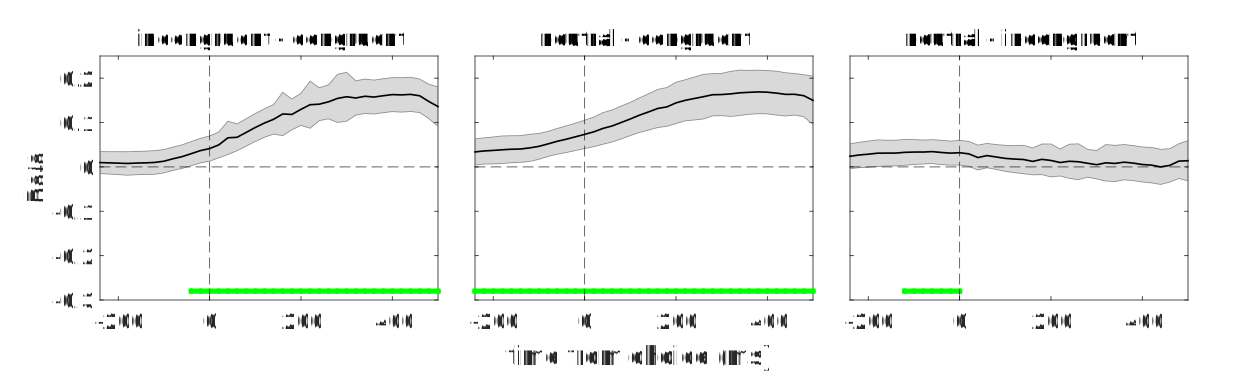

In [11]:
%Fig 5b

set(groot,'DefaultAxesFontSize',15)
this_subplotv = @(m,n,p) subtightplot(m,n,p,.03,[.2 .15],[0.08 0.05]);

plot_params = {{'incongruent - congruent','no prior - congruent',...
    'no prior - incongruent'}};
plot_labels = {{'incongruent - congruent','neutral - congruent',...
    'neutral - incongruent'}};
ylim_min = [-.075 -.3]; %[-.275,-.63];
ylim_max = [.2 .25];
success = [1,0];
success_title = {'correct','incorrect'};
for s=1:length(success)
    figure('Position',[0 0 1000 300])
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        this_plot_labels = plot_labels{pp};
        for i=1:length(this_plot_params)
            %figure('Position',[0 0 325 325]);hold on;
            this_subplotv(1,3,i)
            this_param = this_plot_params{i};
            this_choice_lm = choice_lm(strcmp(choice_lm.param,this_param) & choice_lm.success==choice_lm_success(s),:);
            h_choice_lm=shadedErrorBar(this_choice_lm.time, ...
                this_choice_lm.B, ...
                this_choice_lm.CI_halfwidth, ...
                '-k',1);
            %xlabel('time from choice (ms)')
            if i==1
                ylabel('\it{Beta}','Interpreter','tex')
            else
                set(gca,'Yticklabel',[]) 
            end
                
            title(['\fontsize{14}' this_plot_labels{i}])
            
            h_choice_lm.mainLine.LineWidth = 1;
            hold on;

            %add significance line
            choice_sig = double(this_choice_lm.(p_var) < 0.05);
            choice_sig(choice_sig == 0) = NaN;
            choice_sig_y = ylim_min(s) + (.1 - ylim_min(s))*.05;%min(choice_lm.CI_lower(strcmp(choice_lm.param,this_param))) - .05;
            h_choice_sig = plot(this_choice_lm.time,...
                choice_sig .* choice_sig_y,'.-','LineWidth',3.1, 'Color', 'green','MarkerSize',10);
            yline(0,'--k');
            xline(0,'--k');
            ylim([ylim_min(s) ylim_max(s)]);
            xlim([min(choice_lm.time(choice_lm.success==choice_lm_success(s))) ...
                max(choice_lm.time(choice_lm.success==choice_lm_success(s)))]);

            clear this_choice_lm
            
            %{
            if success(s)==0 && i==2
                %xlabel('time from choice (ms)')
            end
            %}
        end
    end
    if success(s)==0
        suplabel('time from choice (ms)','x',[.09 .2 .84 .84]);
    end
    set(gcf,'Renderer','painters')
end

set(groot,'DefaultAxesFontSize','factory')

#### Confirm no congruent x SNR interaction in this condition
NOPE!

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


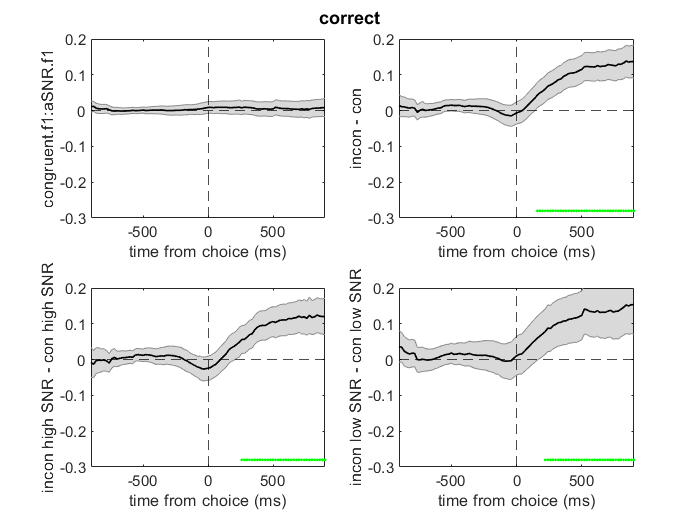

In [12]:
%FINAL

p_var = 'p_corr';

CHOICE_LM_INT_FILE = {'choice_lm_cs_final_2021-06-10.csv',''};
CHOICE_EMM_INT_FILE = {'choice_emm_cs_final_2021-06-10.csv',''};

choice_cs_lm = [];
choice_cs_emm = [];
choice_cs_lm_success = [1 0];
for i=1:1
    this_choice_cs_lm = readtable(CHOICE_LM_INT_FILE{i});
    this_choice_cs_lm.success = repmat(choice_cs_lm_success(i),...
        height(this_choice_cs_lm),1);
    choice_cs_lm = [choice_cs_lm; this_choice_cs_lm];
    
    this_choice_cs_emm = readtable(CHOICE_EMM_INT_FILE{i});
    this_choice_cs_emm.success = repmat(choice_cs_lm_success(i),...
        height(this_choice_cs_emm),1);
    choice_cs_emm = [choice_cs_emm; this_choice_cs_emm];
    
    clear this_choice_cs_lm this_choice_cs_emm
end

choice_cs_lm = [choice_cs_lm;choice_cs_emm];
clear choice_cs_emm;

choice_cs_lm = sortrows(choice_cs_lm,{'success','time','param'}); % {'time','param'});
choice_cs_lm.CI_halfwidth = choice_cs_lm.B - choice_cs_lm.CI_lower;

%restrict to timepoints we are going to actually include in analysis before fdr correct
t_lim = [-900 900];
choice_cs_lm(choice_cs_lm.time<t_lim(1) | choice_cs_lm.time>t_lim(2),:) = [];

%now FDR correct! [NOT IMPLEMENTED IN R as of now]
group_correct = {'incon high SNR - con high SNR','incon low SNR - con low SNR'};
choice_cs_lm = lm_adjust(choice_cs_lm,group_correct);

plot_params = {{'congruent.f1:aSNR.f1','incon - con',...
    'incon high SNR - con high SNR','incon low SNR - con low SNR'}};
ylim_min = [-.3 -.3]; %[-.275,-.63];
success_title = {'correct','incorrect'};
for s=1:1
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        figure();
        for i=1:length(this_plot_params)
            subplot(2,2,i)
            this_param = this_plot_params{i};
            this_choice_cs_lm = choice_cs_lm(strcmp(choice_cs_lm.param,this_param) & choice_cs_lm.success==choice_cs_lm_success(s),:);
            h_choice_cs_lm=shadedErrorBar(this_choice_cs_lm.time, ...
                this_choice_cs_lm.B, ...
                this_choice_cs_lm.CI_halfwidth, ...
                '-k',1);
            xlabel('time from choice (ms)')
            ylabel(this_param)
            h_choice_cs_lm.mainLine.LineWidth = 1;
            hold on;

            choice_cs_sig = double(this_choice_cs_lm.(p_var) < 0.05);
            choice_cs_sig(choice_cs_sig == 0) = NaN;
            choice_cs_sig_y = ylim_min(pp) + (.1 - ylim_min(pp))*.05;%min(choice_cs_lm.CI_lower(strcmp(choice_cs_lm.param,this_param))) - .05;
            h_choice_cs_sig = plot(this_choice_cs_lm.time,...
                choice_cs_sig .* choice_cs_sig_y,'.','LineWidth',1, 'Color', 'green','MarkerSize',5);

            yline(0,'--k');
            xline(0,'--k');
            ylim([ylim_min(pp) .2]);
            xlim([min(choice_cs_lm.time(choice_cs_lm.success==choice_cs_lm_success(s))) ...
                max(choice_cs_lm.time(choice_cs_lm.success==choice_cs_lm_success(s)))]);

            clear this_choice_cs_lm
        end
        suplabel(success_title{s},'t',...
            [.08 .1 .84 .84]);
    end
end


In [13]:
%FINAL

%min corrected p for the interaction?
min(choice_cs_lm.p_corr(choice_cs_lm.success==1 & ...
    strcmp(choice_cs_lm.param,'congruent.f1:aSNR.f1')))
    
min(choice_cs_lm.p(choice_cs_lm.success==1 & ...
    strcmp(choice_cs_lm.param,'congruent.f1:aSNR.f1')))


ans =

    0.9964


ans =

    0.0983



### does psychometric bias relate to pupil congruence effect?

#### correct trials only

Here we perform individual-subject running regressions and then do a spearman's corr with bias at every time point

In [15]:
%load in subject running regressions
conbias_full = readtable(fullfile(SAVE_DIR,'conbias_full_2021-04-04.csv'));


In [16]:
%compute correlations

choice_times_c = unique(conbias_full.time);
conbias_params = unique(conbias_full.param);
%head(conbias_full)

%restrict time points to only include time points also included in full regression
choice_times_c = choice_times_c(choice_times_c>=t_lim(1) & choice_times_c<=t_lim(2));

conbias_rho = [];
for i=1:length(choice_times_c)
    for p=1:length(conbias_params)
        [rho pval]=corr(conbias_full.B(strcmp(conbias_full.param,conbias_params{p}) & ...
            conbias_full.time==choice_times_c(i)),...
            conbias_full.zbias(strcmp(conbias_full.param,conbias_params{p}) & ...
            conbias_full.time==choice_times_c(i)),...
            'type','Spearman');
        this_rho = table(choice_times_c(i),conbias_params(p),rho,pval,'VariableNames',...
            {'time','param','rho','p'});
        conbias_rho = [conbias_rho;this_rho];
    end
end
%head(conbias_rho)

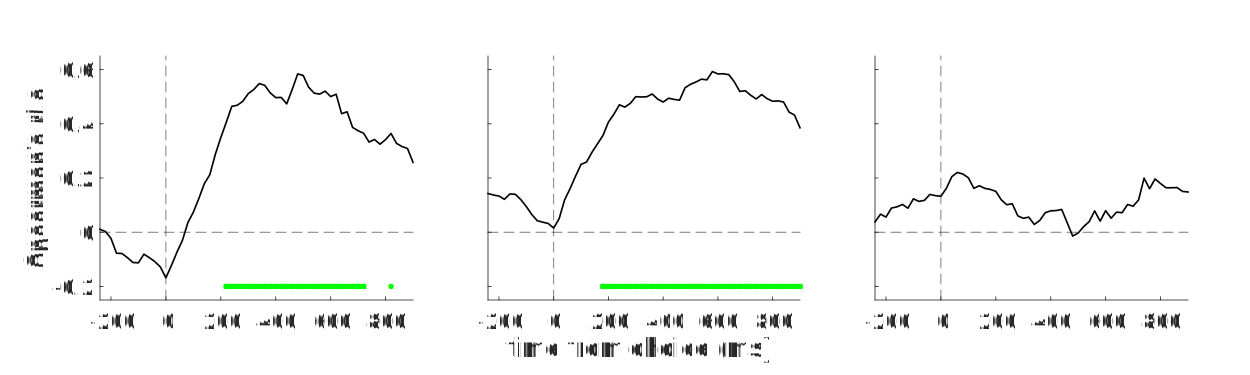

In [17]:
%plot (Fig 5c)
group_correct = {'incongruent - congruent','no prior - congruent', 'no prior - incongruent'};
conbias_rho_contrasts = conbias_rho(ismember(conbias_rho.param,group_correct),:);
conbias_rho_contrasts = lm_adjust(conbias_rho_contrasts,group_correct);
conbias_params_c = unique(conbias_rho_contrasts.param);

set(groot,'DefaultAxesFontSize',15)
this_subplotv = @(m,n,p) subtightplot(m,n,p,.06,[.2 .15],[0.08 0.05]);
p_var = 'p_corr';
conbias_labels = {'incongruent - congruent','no prior - congruent','no prior - incongruent'};
figure('Position',[0 0 1000 300]);
for i=1:length(conbias_params_c)
    this_subplotv(1,3,i);hold on;
    this_cp = conbias_rho_contrasts(strcmp(conbias_rho_contrasts.param,conbias_params_c{i}),:);
    plot(this_cp.time,this_cp.rho,'k','LineWidth',1);
   
    choice_sig = double(this_cp.(p_var) < 0.05);
    choice_sig(choice_sig == 0) = NaN;
    choice_sig_y = -.2; 
    h_choice_sig = plot(this_cp.time,...
        choice_sig .* choice_sig_y,'.-','LineWidth',3.1, 'Color', 'green','MarkerSize',10);
    
    xline(0,'--');
    yline(0,'--');
    ylim([-.25 .65])
    xlim([min(this_cp.time) max(this_cp.time)])
    %title(['\fontsize{14}' conbias_labels{i}])
    if i==1
        ylabel('Spearman''s \it{rho}')
    else
        set(gca,'Yticklabel',[])
    end
end
suplabel('time from choice (ms)','x',[.09 .22 .84 .84]);
set(gcf,'Renderer','painters')
set(groot,'DefaultAxesFontSize','factory')


In [18]:
%what is the span of sig incon - con ps?
conbias_rho_contrasts.time(strcmp(conbias_rho_contrasts.param,{'incongruent - congruent'}) & ...
    conbias_rho_contrasts.p_corr<0.05)


ans =

   220
   240
   260
   280
   300
   320
   340
   360
   380
   400
   420
   440
   460
   480
   500
   520
   540
   560
   580
   600
   620
   640
   660
   680
   700
   720
   820



## Stim-aligned analyses

In [19]:
%% graph relative to stim onset

data_ave_subj = varfun(@nanmean,data(data.trial_time_stimOn >= -500 & data.trial_time_stimOn <= 1500,:),...
    'InputVariables','pupilCblz',...
    'GroupingVariables',{'dataID','trial_time_stimOn'});
data_ave = summary_stats(data_ave_subj,'nanmean_pupilCblz','trial_time_stimOn',1);
 
data_ave_congruent_subj = varfun(@nanmean,data(data.trial_time_stimOn >= -500 & data.trial_time_stimOn <= 1500,:),...
    'InputVariables','pupilCblz',...
    'GroupingVariables',{'dataID','success','congruent','trial_time_stimOn'});
data_ave_congruent = summary_stats(data_ave_congruent_subj,'nanmean_pupilCblz',...
    {'success','congruent','trial_time_stimOn'},1);

congruent=1
congruent=2
congruent=3
congruent=1
congruent=2
congruent=3


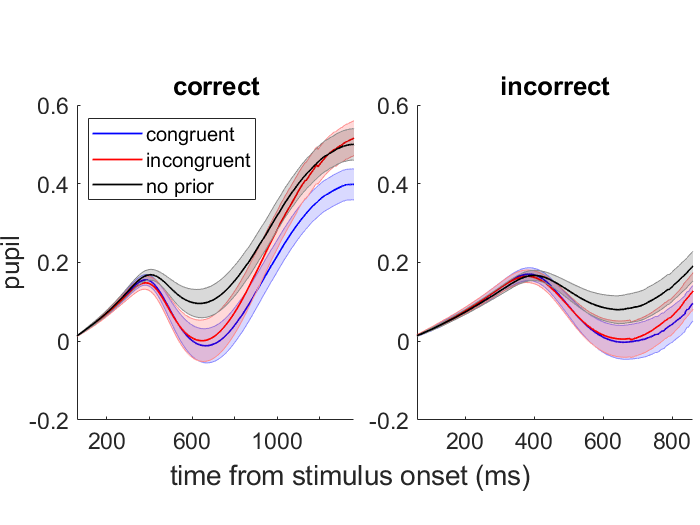

In [20]:
set(groot,'DefaultAxesFontSize',15)
this_subplotv = @(m,n,p) subtightplot(m,n,p,.09,[.2 .2],[0.11 0.01]);

line_specs = {'b','r','k'};
conds = [1,0,-1];
success = [1,0];
success_title = {'correct','incorrect'};
figure()
for c=1:length(success)
    this_subplotv(1,2,c);hold on
    hC = [];
    for j=1:length(conds)
        fprintf('congruent=%d\n',j);

        h=shadedErrorBar(data_ave_congruent.trial_time_stimOn(...
            data_ave_congruent.congruent == conds(j) & data_ave_congruent.success == success(c)), ...
            data_ave_congruent.nanmean_nanmean_pupilCblz(...
            data_ave_congruent.congruent == conds(j) & data_ave_congruent.success == success(c)), ...
            data_ave_congruent.nansem_nanmean_pupilCblz(...
            data_ave_congruent.congruent == conds(j) & data_ave_congruent.success == success(c)), ...
            line_specs{j},1);
        hC = [hC h.mainLine];
    end
    title([success_title(c)])
    %xlabel('time from choice (ms)')
    if success(c)==1
        legend(hC,{'\fontsize{12}congruent', '\fontsize{12}incongruent', '\fontsize{12}no prior'},...
        'Location', 'northwest')
    end
    if success(c)==1
        xlim([60 1360]);
        ylabel('pupil')
    else
        xlim([60 860]);
    end
    ylim([-.2 .6])
    [hC.LineWidth] = deal(1); 
end
suplabel('time from stimulus onset (ms)','x',[.08 .2 .84 .84]);

set(groot,'DefaultAxesFontSize','factory')


### stim-aligned regression

Pupil data were downsampled to 50 Hz. A linear mixed-effects model was then run at every time point between 60 ms and 1360 ms relative to stimulus onset of the form:


$$ pupil_t = \beta_{0_t} + \beta_{congruent1_t} + \beta_{congruent2_t} + \beta_{isH_t} + \beta_{|SNR|_t} + \beta_{bl_t} + \beta_{posX_t} + \beta_{posY_t} $$

Model was only run for correct trials! The model at each time point was initial fit with the maximal random effects structured. In cases of convergence/boundary issues, the complexity of the random effects structure was iteratively reduced following the recommendations of Bates et al., 2015. All categorical variables (congruent, isH) were effect coded. Continuous variables were z-scored across subjects, except for baseline pupil; because it was already z-scored within-subject, it was only mean-centered across subjects.

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


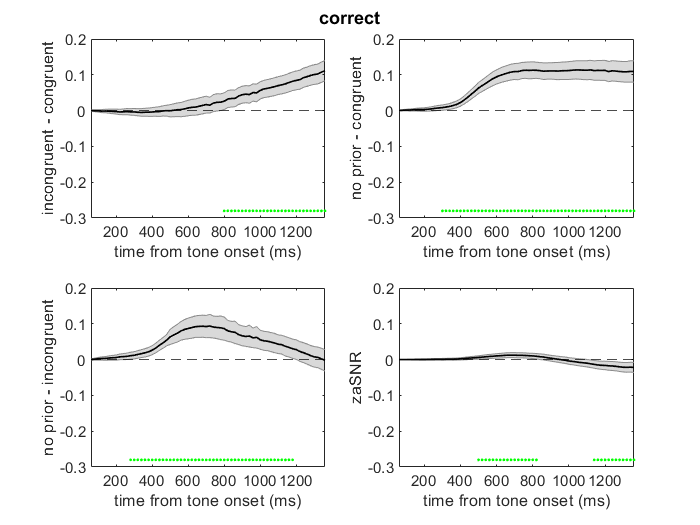

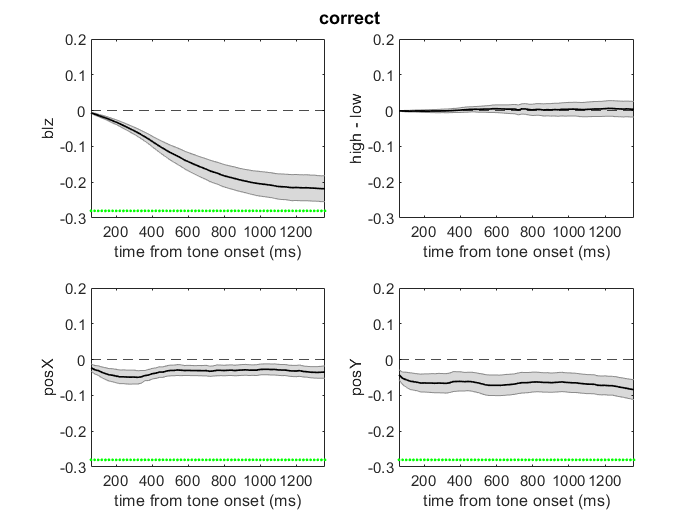

In [21]:
p_var = 'p_corr';

STIM_LM_FILE = {'stim_lm_final_2021-02-14.csv',''};
STIM_EMM_FILE = {'stim_emm_final_2021-02-14.csv',''};

%load regression output
stim_lm = [];
stim_emm = [];
stim_lm_success = [1 0];
for i=1:1 %length(stim_lm_success)
    this_stim_lm = readtable(STIM_LM_FILE{i});
    this_stim_lm.success = repmat(stim_lm_success(i),...
        height(this_stim_lm),1);
    stim_lm = [stim_lm; this_stim_lm];
    
    this_stim_emm = readtable(STIM_EMM_FILE{i});
    this_stim_emm.p_corr = nan(height(this_stim_emm),1);
    this_stim_emm.success = repmat(stim_lm_success(i),...
        height(this_stim_emm),1);
    stim_emm = [stim_emm; this_stim_emm];
    
    clear this_stim_lm this_stim_emm
end
stim_lm = [stim_lm;stim_emm];
clear stim_emm;

%now flip contrasts for ease of interpretation
flip_cs.orig = {'congruent - incongruent','congruent - no prior',...
    'incongruent - no prior'};
flip_cs.new = {'incongruent - congruent','no prior - congruent',...
    'no prior - incongruent'};
flip_lm = stim_lm(ismember(stim_lm.param,flip_cs.orig),:);
flip_lm{:,{'B','t','CI_lower','CI_upper'}} = -flip_lm{:,{'B','t','CI_lower','CI_upper'}};
flip_lm.Properties.VariableNames({'CI_lower','CI_upper'}) = {'CI_upper','CI_lower'};
flip_lm = movevars(flip_lm,'CI_upper','After','CI_lower');
flip_lm.param = replace(flip_lm.param,flip_cs.orig,flip_cs.new);
stim_lm(ismember(stim_lm.param,flip_cs.orig),:) = flip_lm;
clear flip_lm

stim_lm = sortrows(stim_lm,{'success','time','param'}); % {'time','param'});
stim_lm.CI_halfwidth = stim_lm.B - stim_lm.CI_lower;

%now FDR correct! [NOT IMPLEMENTED IN R as of now]
group_correct = {'incongruent - congruent','no prior - congruent', 'no prior - incongruent'};
stim_lm = lm_adjust(stim_lm,group_correct);

plot_params = {{'incongruent - congruent','no prior - congruent',...
    'no prior - incongruent','zaSNR'},{'blz','high - low','posX','posY'}};
ylim_min = [-.3 -.3]; %[-.275,-.63];
for s=1:1 %length(stim_lm_success)
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        figure();
        for i=1:length(this_plot_params)
            subplot(2,2,i)
            this_param = this_plot_params{i};
            this_stim_lm = stim_lm(strcmp(stim_lm.param,this_param) & stim_lm.success==stim_lm_success(s),:);
            h_stim_lm=shadedErrorBar(this_stim_lm.time, ...
                this_stim_lm.B, ...
                this_stim_lm.CI_halfwidth, ...
                '-k',1);
            xlabel('time from tone onset (ms)')
            ylabel(this_param)
            h_stim_lm.mainLine.LineWidth = 1;
            hold on;

            %add significance line
            stim_sig = double(this_stim_lm.(p_var) < 0.05);
            stim_sig(stim_sig == 0) = NaN;
            stim_sig_y = ylim_min(pp) + (.1 - ylim_min(pp))*.05;%min(stim_lm.CI_lower(strcmp(stim_lm.param,this_param))) - .05;
            h_stim_sig = plot(this_stim_lm.time,...
                stim_sig .* stim_sig_y,'.','LineWidth',1, 'Color', 'green','MarkerSize',5);
            yline(0,'--k');
            xline(0,'--k');
            ylim([ylim_min(pp) .2]);
            xlim([min(stim_lm.time(stim_lm.success==stim_lm_success(s))) ...
                max(stim_lm.time(stim_lm.success==stim_lm_success(s)))]);

            clear this_stim_lm
        end
        %suplabel(sprintf('success=%d',stim_lm_success(s)),'t',...
        %    [.08 .1 .84 .84]);
        suplabel(success_title{s},'t',...
            [.08 .1 .84 .84]);
    end
end